In [1]:
import pandas as pd
import numpy as np
import tsfel

In [2]:
data = pd.read_csv("nyc_energy.csv", parse_dates=['timeStamp']).sort_values(by='timeStamp') 

In [3]:
X_train= data[data['timeStamp'] < '2017-02-01']
X_test= data[data['timeStamp'] >= '2017-02-01']

y_train = X_train.pop('demand').values
print(len(y_train))

y_test = X_test.pop('demand').values
print(len(y_test))

X_train = X_train[['precip', 'temp']]
print(len(X_train.index))

X_test = X_test[['precip', 'temp']]
print(len(X_test.index))


44567
4557
44567
4557


In [5]:
def pad_zeros(data, window_size=24):
    zero_pad = pd.DataFrame(np.zeros(shape=(window_size,len(data.columns))),columns=data.columns)
    pre_pad_zeros_data = pd.concat([zero_pad,data]).reset_index(drop=True)
    return pre_pad_zeros_data   

In [7]:
X_train_p = pad_zeros(X_train)
print(len(X_train_p.index))

X_test_p = pad_zeros(X_test)
print(len(X_test_p.index))

cfg_file = {}
cfg_file['temporal'] = tsfel.get_features_by_domain('temporal')['temporal']
cfg_file['statistical'] = tsfel.get_features_by_domain('statistical')['statistical']


44591
4581


In [8]:
x_train_feat = tsfel.time_series_features_extractor(cfg_file, X_train_p, window_size=24,overlap=.90,header_names=['precip','temp'])
print(len(x_train_feat.index))
print(len(x_train_feat.columns))


*** Feature extraction started ***


/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Using default sampling frequency set in configuration file.
  """Entry point for launching an IPython kernel.


/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)
/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)
/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)
/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)
/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-pa


*** Feature extraction finished ***
22284
110


In [9]:
x_test_feat = tsfel.time_series_features_extractor(cfg_file, X_test_p, window_size=24,overlap=.90,header_names=['precip','temp'])
print(len(x_test_feat.index))
print(len(x_test_feat.columns))

*** Feature extraction started ***


/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Using default sampling frequency set in configuration file.
  """Entry point for launching an IPython kernel.


/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)
/Users/shona/PycharmProjects/nyc_energy_forecast/.venv/lib/python3.7/site-packages/tsfel/feature_extraction/features.py:769: RuntimeWarning: divide by zero encountered in double_scalars
  return (p_end - p_init) / (x_end - x_init)


In [8]:
import optuna
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

In [9]:
def fill_missing_values(df):
    """ Handle eventual missing data. Strategy: replace with mean.
    
      Parameters
      ----------
      df pandas DataFrame
      Returns
      -------
        Data Frame without missing values.
    """
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

In [10]:
# Handling eventual missing values from the feature extraction
x_train_feat_a = pd.concat([X_train.reset_index(drop=True),x_train_feat],axis=1)
x_test_feat_a = pd.concat([X_test.reset_index(drop=True),x_test_feat],axis=1)

In [11]:
len(x_train_feat_a.columns)

106

In [12]:
x_train_feat_a = fill_missing_values(x_train_feat_a)
x_test_feat_a = fill_missing_values(x_test_feat_a)

In [13]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(x_train_feat_a)
x_train_feat_a.drop(corr_features, axis=1, inplace=True)
x_test_feat_a.drop(corr_features, axis=1, inplace=True)

In [14]:
# Remove low variance features
selector = VarianceThreshold()
selector.fit(x_train_feat_a)
x_train_feat_a = x_train_feat_a.loc[:,selector.get_support()]
x_test_feat_a = x_test_feat_a.loc[:,selector.get_support()]

In [15]:
len(x_train_feat_a.index)

44567

In [16]:
# Normalising Features
min_max_scaler = preprocessing.StandardScaler()
nX_train = min_max_scaler.fit_transform(x_train_feat_a)
nX_test = min_max_scaler.transform(x_test_feat_a)

In [17]:
# Step 1. Define an objective function to be maximized.
def objective(trial):
    regressor_name = trial.suggest_categorical("regressor", ["RandomForestRegressor", "XGBRegressor"])

    # Step 2. Setup values for the hyperparameters:
    if regressor_name == 'RandomForestRegressor':
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 100)
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
        regressor_obj = RandomForestRegressor(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
    else:
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 10, 100)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 32, log=True)
        regressor_obj = XGBRegressor(max_depth=xgb_max_depth, n_estimators=xgb_n_estimators)

    # tscv = model_selection.TimeSeriesSplit(n_splits=3)
    #Step 3: Scoring method:
    score = model_selection.cross_val_score(regressor_obj, nX_train, y_train, n_jobs=-1, scoring = "neg_mean_absolute_error", cv=3)
    loss = score.mean()
#     regressor_obj.fit(nX_train, y_train)
#     train_pred = regressor_obj.predict(nX_train)
#     loss = mean_absolute_error(y_train, train_pred)
    return loss 


In [18]:
# Step 4: Running it
from optuna.samplers import TPESampler
study = optuna.create_study(direction="maximize", sampler=TPESampler())
study.optimize(objective, n_trials=25)

[I 2020-09-10 13:42:02,532] Trial 0 finished with value: -606.648974780057 and parameters: {'regressor': 'RandomForestRegressor', 'rf_n_estimators': 91, 'rf_max_depth': 8}. Best is trial 0 with value: -606.648974780057.
[I 2020-09-10 13:42:06,113] Trial 1 finished with value: -600.0141087640817 and parameters: {'regressor': 'XGBRegressor', 'xgb_n_estimators': 76, 'xgb_max_depth': 3}. Best is trial 1 with value: -600.0141087640817.
[I 2020-09-10 13:42:16,326] Trial 2 finished with value: -605.2987155603643 and parameters: {'regressor': 'RandomForestRegressor', 'rf_n_estimators': 29, 'rf_max_depth': 24}. Best is trial 1 with value: -600.0141087640817.
[I 2020-09-10 13:42:32,177] Trial 3 finished with value: -598.9775382179604 and parameters: {'regressor': 'RandomForestRegressor', 'rf_n_estimators': 64, 'rf_max_depth': 13}. Best is trial 3 with value: -598.9775382179604.
[I 2020-09-10 13:42:41,755] Trial 4 finished with value: -640.0789356137426 and parameters: {'regressor': 'XGBRegressor

In [19]:
print('Minimum mean squared error: ' + str(study.best_value))
print('Best parameter: ' + str(study.best_params))

study.trials_dataframe()


Minimum mean squared error: -596.7898031614675
Best parameter: {'regressor': 'XGBRegressor', 'xgb_n_estimators': 66, 'xgb_max_depth': 5}


,number,value,datetime_start,datetime_complete,duration,params_regressor,params_rf_max_depth,params_rf_n_estimators,params_xgb_max_depth,params_xgb_n_estimators,state
0,0,-606.648975,2020-09-10 13:41:48.050931,2020-09-10 13:42:02.531106,0 days 00:00:14.480175,RandomForestRegressor,8.0,91.0,NaN,NaN,COMPLETE
1,1,-600.014109,2020-09-10 13:42:02.535507,2020-09-10 13:42:06.112876,0 days 00:00:03.577369,XGBRegressor,NaN,NaN,3.0,76.0,COMPLETE
2,2,-605.298716,2020-09-10 13:42:06.115753,2020-09-10 13:42:16.325784,0 days 00:00:10.210031,RandomForestRegressor,24.0,29.0,NaN,NaN,COMPLETE
3,3,-598.977538,2020-09-10 13:42:16.329149,2020-09-10 13:42:32.176727,0 days 00:00:15.847578,RandomForestRegressor,13.0,64.0,NaN,NaN,COMPLETE
4,4,-640.078936,2020-09-10 13:42:32.179322,2020-09-10 13:42:41.754778,0 days 00:00:09.575456,XGBRegressor,NaN,NaN,28.0,22.0,COMPLETE
5,5,-665.281850,2020-09-10 13:42:41.758508,2020-09-10 13:42:47.350174,0 days 00:00:05.591666,RandomForestRegressor,3.0,83.0,NaN,NaN,COMPLETE
6,6,-597.864551,2020-09-10 13:42:47.353455,2020-09-10 13:42:50.196621,0 days 00:00:02.843166,XGBRegressor,NaN,NaN,5.0,34.0,COMPLETE
7,7,-599.593596,2020-09-10 13:42:50.199651,2020-09-10 13:43:16.618852,0 days 00:00:26.419201,RandomForestRegressor,18.0,87.0,NaN,NaN,COMPLETE
8,8,-620.686808,2020-09-10 13:43:16.622143,2020-09-10 13:43:29.819769,0 days 00:00:13.197626,XGBRegressor,NaN,NaN,10.0,97.0,COMPLETE
9,9,-614.137115,2020-09-10 13:43:29.822919,2020-09-10 13:43:30.751872,0 days 00:00:00.928953,XGBRegressor,NaN,NaN,3.0,15.0,COMPLETE


In [20]:
#applying SGDRegressor with best hyper-parameter
clf = XGBRegressor(max_depth=study.best_params['xgb_max_depth'],n_estimators=study.best_params['xgb_n_estimators'])
clf.fit(nX_train, y_train)

train_pred = clf.predict(nX_train)
train_MAPE = mean_absolute_error(y_train, train_pred)/ (sum(y_train)/len(y_train))
train_MSE = mean_squared_error(y_train, train_pred)


test_pred = clf.predict(nX_test)
test_MAPE = mean_absolute_error(y_test, test_pred)/ (sum(y_test)/len(y_test))
test_MSE = mean_squared_error(y_test, test_pred)

In [21]:
test_MAPE

0.08988252040121417

In [26]:
fi = dict(zip(x_train_feat_a.columns,clf.feature_importances_))

In [28]:
plot_importance_df = pd.DataFrame.from_dict(fi,orient='index',columns=['Importance'])
plot_importance_df.head()


,Importance
precip,0.007498
temp,0.485947
precip_Absolute energy,0.007875
precip_Area under the curve,0.009065
precip_Centroid,0.009930


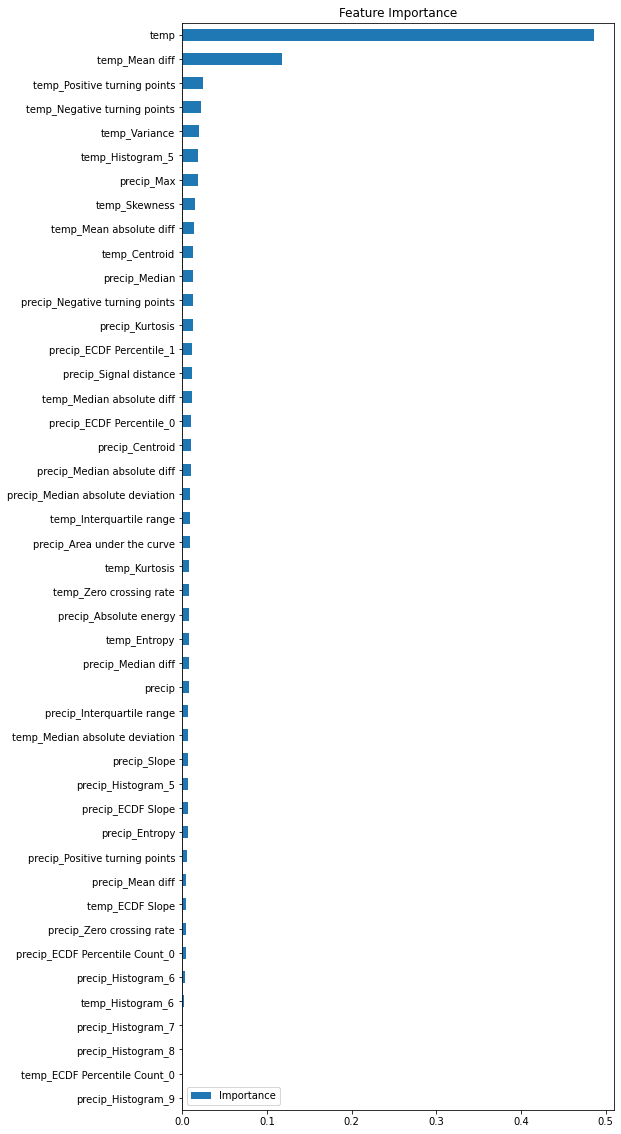

In [40]:
import matplotlib.pyplot as plt

final_plot_imp_df = plot_importance_df.iloc[plot_importance_df['Importance'].abs().argsort()]
final_plot_imp_df.plot(kind='barh', figsize=(10, 20))
plt.title('Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

[('precip', -0.2809127), ('temp', 0.6606249), ('precip_Absolute energy', -0.39627114), ('precip_Area under the curve', 1.1719327), ('precip_Centroid', -19.701424), ('precip_ECDF Percentile Count_0', 9.051857), ('precip_ECDF Percentile_0', 3.8964424), ('precip_ECDF Percentile_1', 0.0), ('precip_ECDF Slope', -0.5601129), ('precip_Entropy', 0.0), ('precip_Histogram_5', 0.59341353), ('precip_Histogram_6', 23.183138), ('precip_Histogram_7', 1.7487683), ('precip_Histogram_8', 31.486134), ('precip_Histogram_9', -0.646571), ('precip_Interquartile range', -25.148878), ('precip_Kurtosis', 0.0), ('precip_Max', -2.5479548), ('precip_Mean diff', 10.172111), ('precip_Median', -1.2755972), ('precip_Median absolute deviation', 4.0917444), ('precip_Median absolute diff', -1.0644184), ('precip_Median diff', 0.567524), ('precip_Negative turning points', 0.0), ('precip_Positive turning points', -8.155094), ('precip_Signal distance', 0.0), ('precip_Slope', -19.484255), ('precip_Zero crossing rate', -160.25

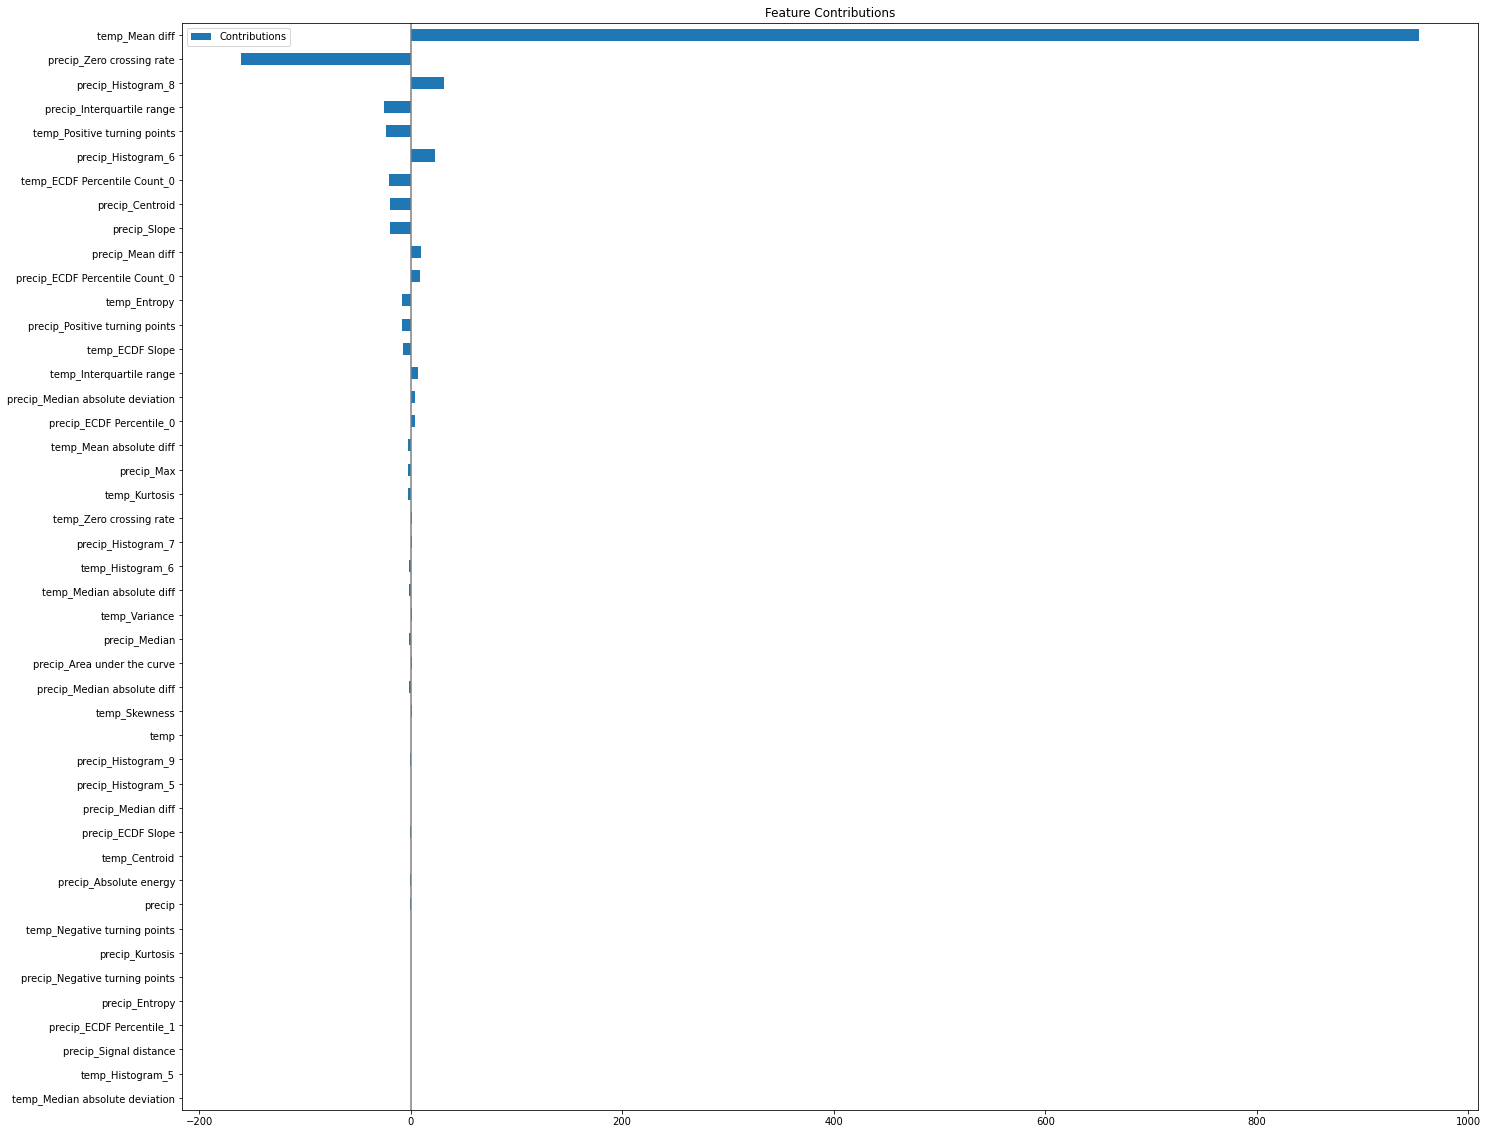

In [42]:
from transparency.python.explainer.ensemble_tree import EnsembleTreeExplainer, EnsembleTreeExplainerTransformer

columns = x_train_feat_a.columns

# prediction explanation generation
expl = EnsembleTreeExplainer(clf)
contributions, contrib_intercept = expl.predict(nX_test)
average_contribs = list(zip(columns, np.mean(contributions, axis=0)))
print(average_contribs)

# Plotting mean feature contributions over the total population
plot_contrib_df = pd.DataFrame(np.mean(contributions, axis=0), index=columns, columns=['Contributions'])
final_plot_contrib_df = plot_contrib_df.iloc[plot_contrib_df['Contributions'].abs().argsort()]
final_plot_contrib_df.plot(kind='barh', figsize=(30, 20))
plt.title('Feature Contributions')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)
plt.show()